In [1]:
### TO-DOs ###
# DBSCAN get value_counts for epsilons in range(12,18)
# Export datasets with:
# school_name, school_address, label, score (e.g. silhouette_coefficient)

## Imports

#### Import packages

In [259]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
viz_config = {'color': 'c', 'alpha': 0.4}
sns.set_context('paper')

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

random_state=42

#### Import data

In [3]:
school_data = pd.read_csv('raw_data/schools.csv', header=0, index_col=0)

In [4]:
income_data = pd.read_csv('raw_data/incomes.csv', header=0, names=['zip', 'income'])

## Exploratory Data Analysis

#### School data

In [5]:
school_data.head()

,Address,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
A.N. Pritzker School,"2009 W Schiller St, Chicago, IL 60622",63,46,42,70,45
ACE Technical Charter School,"5410 S State St, Chicago, IL 60609",79,71,65,70,46
ASPIRA Business and Finance,"2989 N Milwaukee Ave, Chicago, IL 60618",55,32,16,25,49
ASPIRA Charter School - Early College High School,"3986 W Barry Ave, Chicago, IL 60618",72,64,52,75,64
ASPIRA Charter School - Haugan Middle School,"3729 W Leland Ave, Chicago, IL 60625",99,87,80,80,60


There is a mistake in the data: the zip code for George Washington Carver Military Academy HS is supposed to be 60827, not 60627.

In [6]:
# Function to extract zip code out of an address
get_zip = lambda x: x.split()[-1]

# View the problematic entry
cond_zip_60627 = school_data['Address'].apply(get_zip) == '60627'
school_data.loc[cond_zip_60627]

,Address,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
George Washington Carver Military Academy HS,"13100 S Doty Ave, Chicago, IL 60627",75,74,59,82,56


In [7]:
# Replace zip code with correct one: 60827
school_data.loc[cond_zip_60627, 'Address'] = '13100 S Doty Ave, Chicago, IL 60827'

# Check that the replacement worked
school_data.loc[cond_zip_60627]

,Address,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
George Washington Carver Military Academy HS,"13100 S Doty Ave, Chicago, IL 60827",75,74,59,82,56


In [8]:
school_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, A.N. Pritzker School to Young Women's Leadership Charter School
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Address                 655 non-null    object
 1   Ambitious_Instruction   655 non-null    int64 
 2   Collaborative_Teachers  655 non-null    int64 
 3   Effective_Leaders       655 non-null    int64 
 4   Involved_Families       655 non-null    int64 
 5   Supportive_Environment  655 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 35.8+ KB


In [9]:
school_data.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
count,655.000000,655.000000,655.000000,655.000000,655.000000
mean,69.600000,59.981679,53.824427,61.665649,50.581679
std,23.629764,19.359696,17.555800,21.361594,21.584674
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,61.500000,49.000000,44.000000,51.000000,39.500000
50%,74.000000,62.000000,56.000000,63.000000,51.000000
75%,86.000000,73.000000,66.000000,77.000000,63.000000
max,99.000000,99.000000,98.000000,99.000000,99.000000


The web-crawling 'spider' inserted -1 for missing values. Schools that didn't have numbers for any of the categories were skipped in the process.

In [10]:
# Replace -1 with NaN
school_data[(school_data == -1)] = np.NaN

In [11]:
# Count NaNs by column
school_data.isna().sum()

Address                    0
Ambitious_Instruction     43
Collaborative_Teachers    14
Effective_Leaders         15
Involved_Families         24
Supportive_Environment    43
dtype: int64

In [12]:
# Count rows with too many NaNs
max_nans_allowed = 2
rows_too_many_nans = school_data.isna().sum(axis=1) > max_nans_allowed
len(school_data[rows_too_many_nans])

15

If we allow a maximum of 1 missing value per row, we lose 58 instances... almost 10% of our dataset. With max_nans_allowed set at 2, we only lose 15 instances.

In [13]:
# New DataFrame without too many NaNs on each row
school_df = school_data[~rows_too_many_nans]

In [14]:
# Create separate Series for addresses
school_addresses = school_df.iloc[:, 0]

# Discard 'Address' column from DataFrame
school_df = school_df.iloc[:, 1:]

school_addresses

A.N. Pritzker School                                       2009 W Schiller St, Chicago, IL 60622
ACE Technical Charter School                                  5410 S State St, Chicago, IL 60609
ASPIRA Business and Finance                              2989 N Milwaukee Ave, Chicago, IL 60618
ASPIRA Charter School - Early College High School            3986 W Barry Ave, Chicago, IL 60618
ASPIRA Charter School - Haugan Middle School                3729 W Leland Ave, Chicago, IL 60625
                                                                        ...                     
YCCS - Sullivan House Alternative HS                 8164 S South Chicago Ave, Chicago, IL 60617
YCCS - Truman Middle College HS                             1145 W Wilson Ave, Chicago, IL 60640
YCCS - West Town Acad Alternative HS                    500 N Sacramento Blvd, Chicago, IL 60612
YCCS - Youth Connection Leadership Acad HS                    3424 S State St, Chicago, IL 60616
Young Women's Leadership Chart

In [15]:
school_df.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
count,598.000000,640.000000,639.000000,631.000000,598.000000
mean,74.760870,61.329687,55.100156,64.049128,54.170569
std,14.790486,17.325542,15.606324,17.844099,17.344408
min,32.000000,16.000000,4.000000,7.000000,12.000000
25%,64.000000,50.000000,46.000000,52.000000,42.000000
50%,75.000000,63.000000,56.000000,64.000000,53.000000
75%,87.000000,74.000000,66.000000,78.000000,64.000000
max,99.000000,99.000000,98.000000,99.000000,99.000000


In [16]:
# Fill NaNs with their respective row's mean
school_df = school_df.apply(lambda row: row.fillna(row.median()), axis=1)

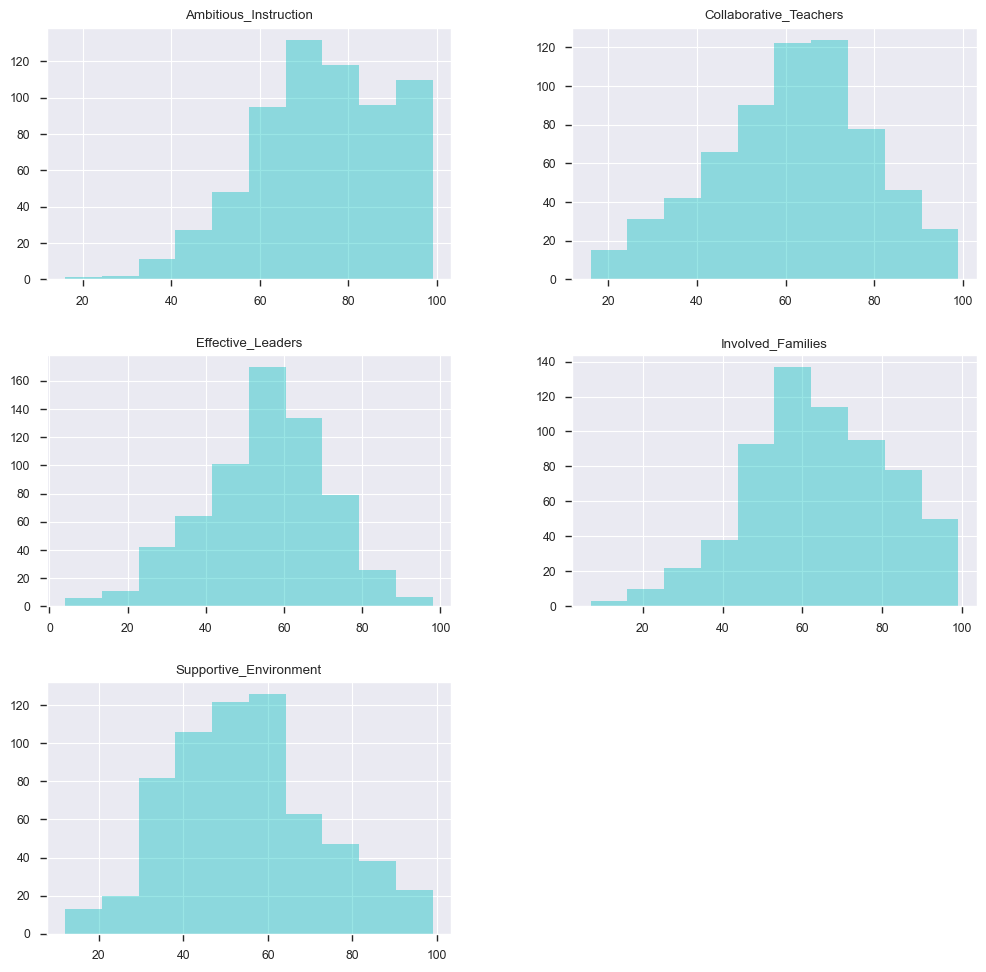

In [17]:
school_df.hist(figsize=(12,12), **viz_config);

#### Income data

In [18]:
income_data.head()

,zip,income
0,60007,75743.0
1,60018,60566.0
2,60106,67325.0
3,60131,57815.0
4,60176,53360.0


In [19]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   zip     68 non-null     int64  
 1   income  67 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [20]:
income_data.isna().sum()

zip       0
income    1
dtype: int64

In [21]:
# Find rows with income NaN
cond_isna = income_data.iloc[:, 1].isna()
income_data.loc[cond_isna]

,zip,income
44,60642,NaN


In [22]:
# Find rows with income 0
cond_zero = income_data.iloc[:, 1] == 0
income_data.loc[cond_zero]

,zip,income
54,60654,0.0
61,60666,0.0


In [23]:
# Calculate median for the income column
income_median = income_data.iloc[:,1].median()

# Assign income_median to the locations where conditions return True
income_data.iloc[(cond_isna | cond_zero).values, 1] = income_median

In [24]:
# Describe the income column
income_data.iloc[:,1].describe()

count        68.000000
mean      56778.794118
std       23573.079579
min       18464.000000
25%       42493.250000
50%       54344.000000
75%       63822.500000
max      171463.000000
Name: income, dtype: float64

### Join dataframes

In [25]:
# Create zip column in school_df to use in the merge
school_df['zip'] = school_addresses.apply(lambda x: x.split()[-1])
school_df['zip'] = school_df['zip'].astype('int64')
school_df.head()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment,zip
A.N. Pritzker School,63.0,46.0,42.0,70.0,45.0,60622
ACE Technical Charter School,79.0,71.0,65.0,70.0,46.0,60609
ASPIRA Business and Finance,55.0,32.0,16.0,25.0,49.0,60618
ASPIRA Charter School - Early College High School,72.0,64.0,52.0,75.0,64.0,60618
ASPIRA Charter School - Haugan Middle School,99.0,87.0,80.0,80.0,60.0,60625


In [26]:
merged_df = pd.merge(school_df, income_data, how='left', on='zip')
merged_df.head()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment,zip,income
0,63.0,46.0,42.0,70.0,45.0,60622,54344.0
1,79.0,71.0,65.0,70.0,46.0,60609,31357.0
2,55.0,32.0,16.0,25.0,49.0,60618,55303.0
3,72.0,64.0,52.0,75.0,64.0,60618,55303.0
4,99.0,87.0,80.0,80.0,60.0,60625,53288.0


In [27]:
merged_df.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment,zip,income
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,74.139062,61.329687,55.126562,63.998438,54.900000,60630.142188,45439.895312
std,15.274362,17.325542,15.608410,17.861929,17.665099,22.821964,13279.991805
min,16.000000,16.000000,4.000000,7.000000,12.000000,60602.000000,18464.000000
25%,64.000000,50.000000,46.000000,52.000000,42.000000,60618.000000,34670.000000
50%,75.000000,63.000000,56.000000,64.000000,53.000000,60625.000000,45717.000000
75%,87.000000,74.000000,66.000000,78.000000,66.000000,60639.000000,54344.000000
max,99.000000,99.000000,98.000000,99.000000,99.000000,60827.000000,93702.000000


In [28]:
# Delete the zip column
merged_df.drop('zip', axis=1, inplace=True)

#### Scale income

All features except for income have similar ranges: 0 to 100 (or 99 if we want to be precise). In order for the clustering algorithms to properly detect patterns in the data, we want income to be in the same range.

In [29]:
max_income = max(merged_df['income'])

merged_df['income'] = (merged_df['income'] / max_income) * 100

In [30]:
merged_df.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment,income
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,74.139062,61.329687,55.126562,63.998438,54.900000,48.494051
std,15.274362,17.325542,15.608410,17.861929,17.665099,14.172581
min,16.000000,16.000000,4.000000,7.000000,12.000000,19.705022
25%,64.000000,50.000000,46.000000,52.000000,42.000000,37.000277
50%,75.000000,63.000000,56.000000,64.000000,53.000000,48.789780
75%,87.000000,74.000000,66.000000,78.000000,66.000000,57.996628
max,99.000000,99.000000,98.000000,99.000000,99.000000,100.000000


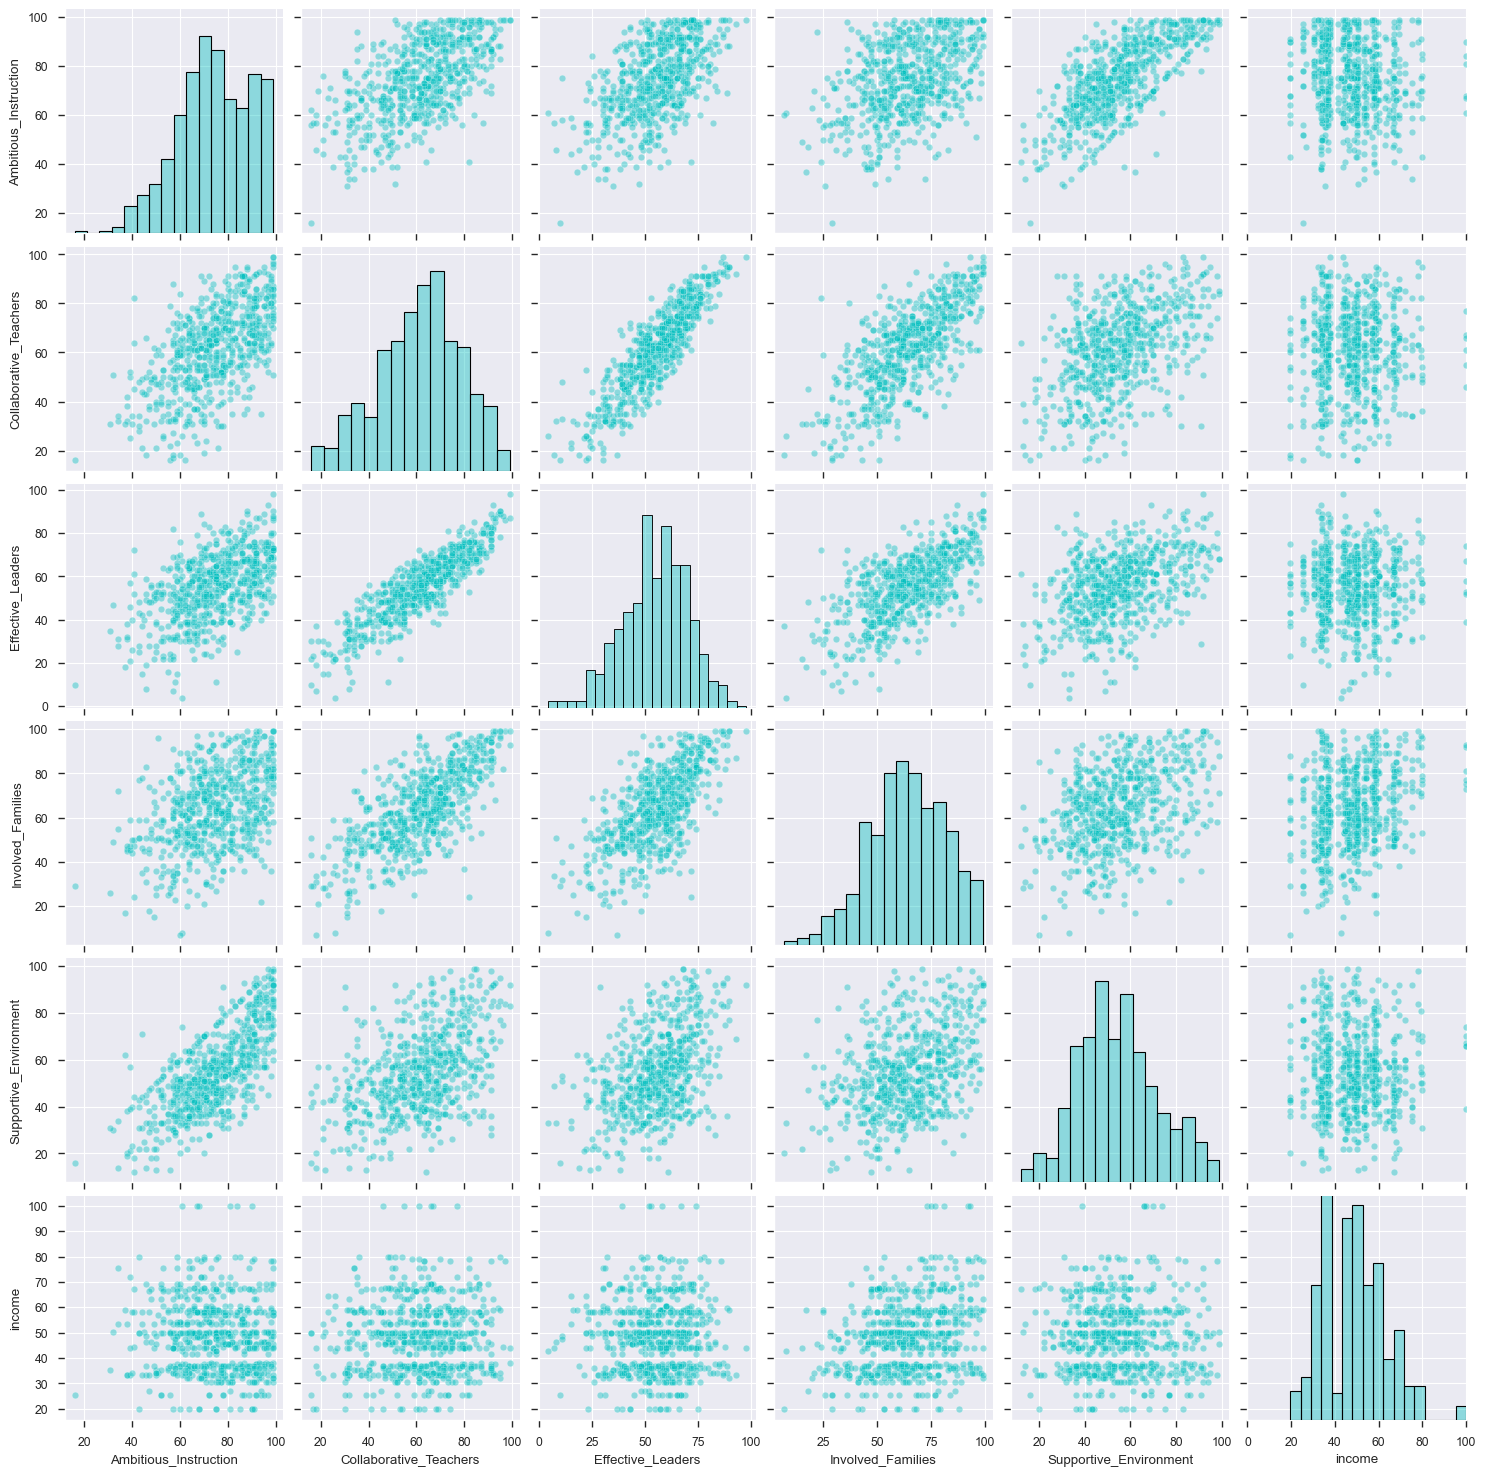

In [31]:
sns.pairplot(merged_df,
             diag_kind='hist', 
             plot_kws=viz_config,
             diag_kws=viz_config)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show();

In [32]:
columns = list(merged_df.columns)

In [33]:
get_fresh_X = lambda : merged_df.values

In [34]:
X = get_fresh_X()

### K-Means

In [35]:
k=5
kmeans = KMeans(n_clusters=k, random_state=random_state)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [36]:
kmeans.cluster_centers_

array([[85.08088235, 60.95588235, 54.83823529, 57.85294118, 65.69852941,
        39.71649171],
       [62.70700637, 52.39490446, 47.46496815, 55.19426752, 42.98726115,
        49.73684021],
       [91.05172414, 82.20689655, 72.99137931, 84.3362069 , 76.07758621,
        48.32514707],
       [72.42675159, 69.17834395, 62.07643312, 74.89171975, 49.82165605,
        57.23448112],
       [55.40540541, 31.59459459, 29.16216216, 38.97972973, 37.90540541,
        43.70993264]])

In [37]:
# Clusters assigned to first 20 instances
kmeans.labels_[:20]

array([1, 3, 4, 3, 2, 3, 2, 1, 1, 1, 2, 4, 1, 1, 3, 4, 4, 3, 4, 1],
      dtype=int32)

In [38]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=random_state).fit(X) for k in range(2,11)]

In [39]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]
silhouette_scores

[0.30041647540215777,
 0.2306680111476381,
 0.2220060853454789,
 0.19567506386787337,
 0.18978166241787892,
 0.18392742437008303,
 0.17933835010073498,
 0.16760485720748247,
 0.1686483830857648]

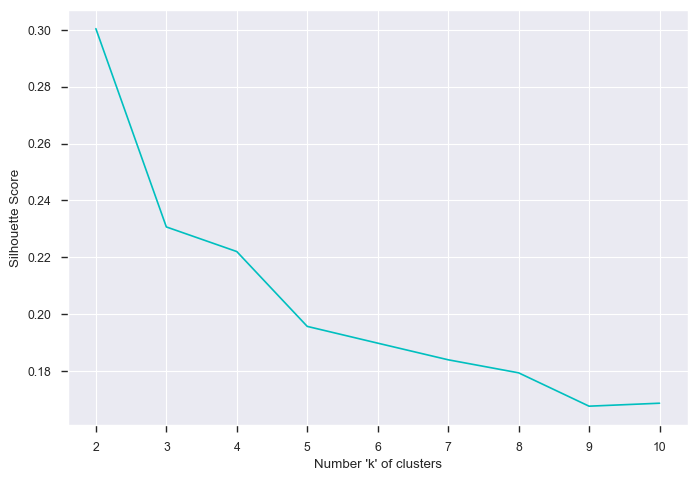

In [40]:
plt.plot(range(2,11), silhouette_scores, color='c')
plt.xlabel('Number \'k\' of clusters')
plt.ylabel('Silhouette Score');

For n_clusters = 2 The average silhouette_score is : 0.30041647540215777
For n_clusters = 3 The average silhouette_score is : 0.2306680111476381
For n_clusters = 4 The average silhouette_score is : 0.22211913169089734
For n_clusters = 5 The average silhouette_score is : 0.19567506386787337
For n_clusters = 6 The average silhouette_score is : 0.18925139577819725
For n_clusters = 7 The average silhouette_score is : 0.18264954705692205
For n_clusters = 8 The average silhouette_score is : 0.1783099846370517
For n_clusters = 9 The average silhouette_score is : 0.17488159569859482
For n_clusters = 10 The average silhouette_score is : 0.1694002549958989


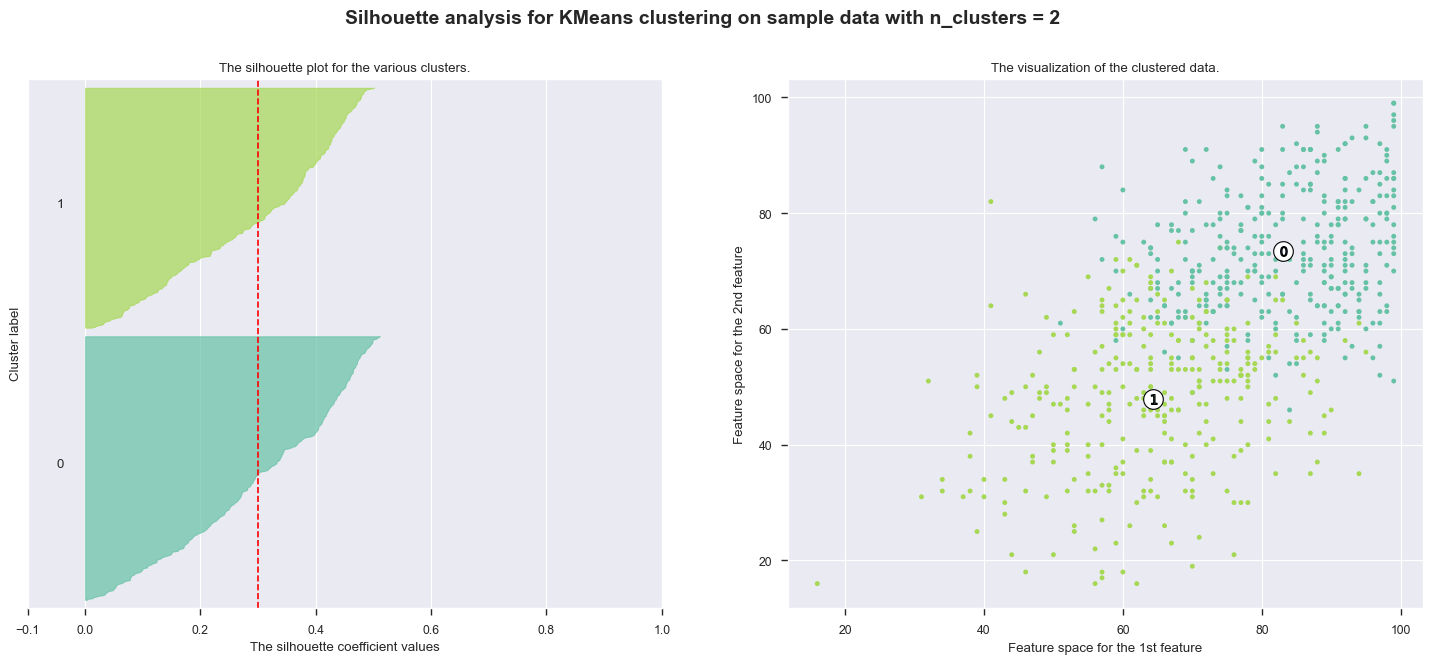

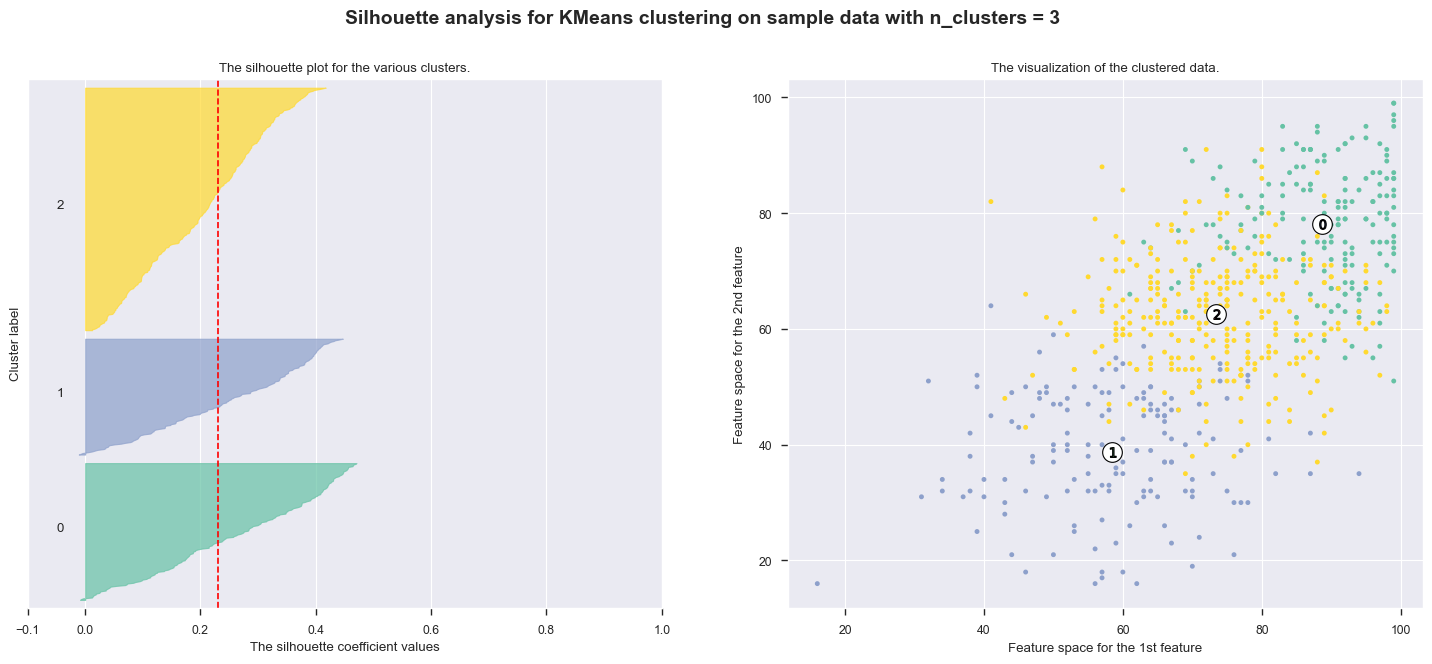

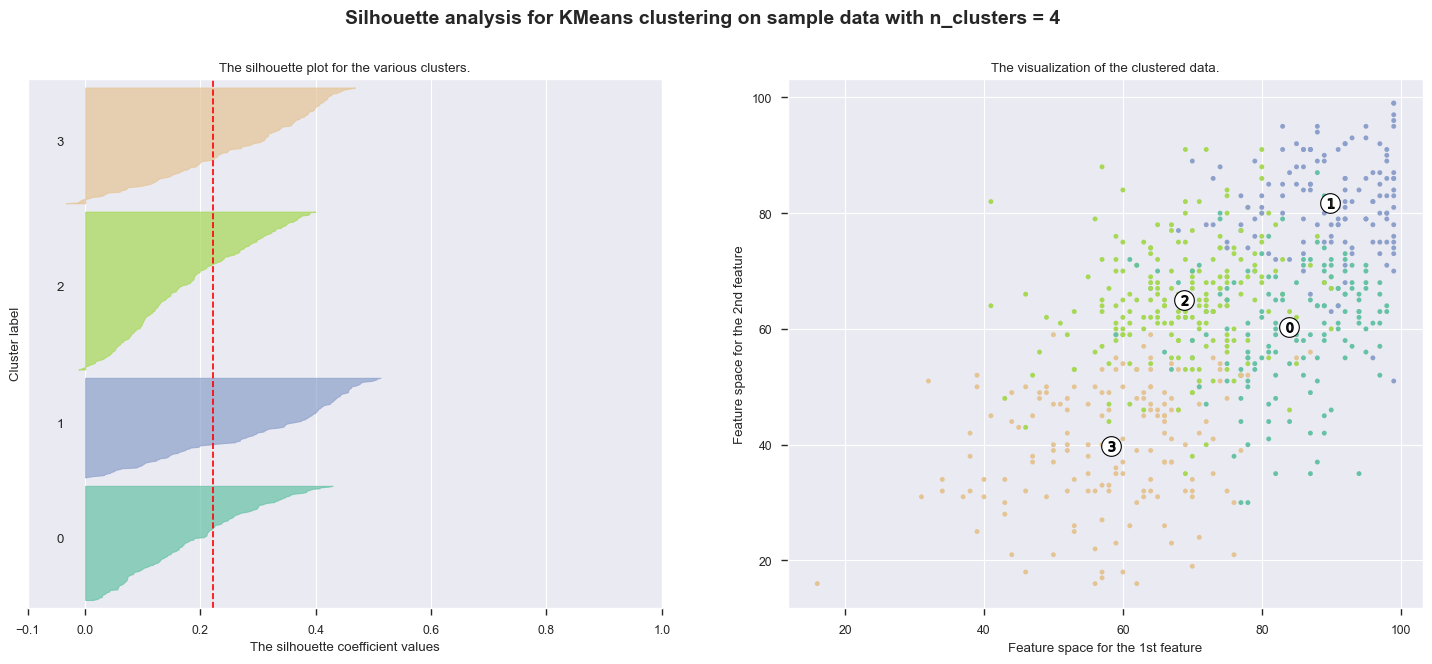

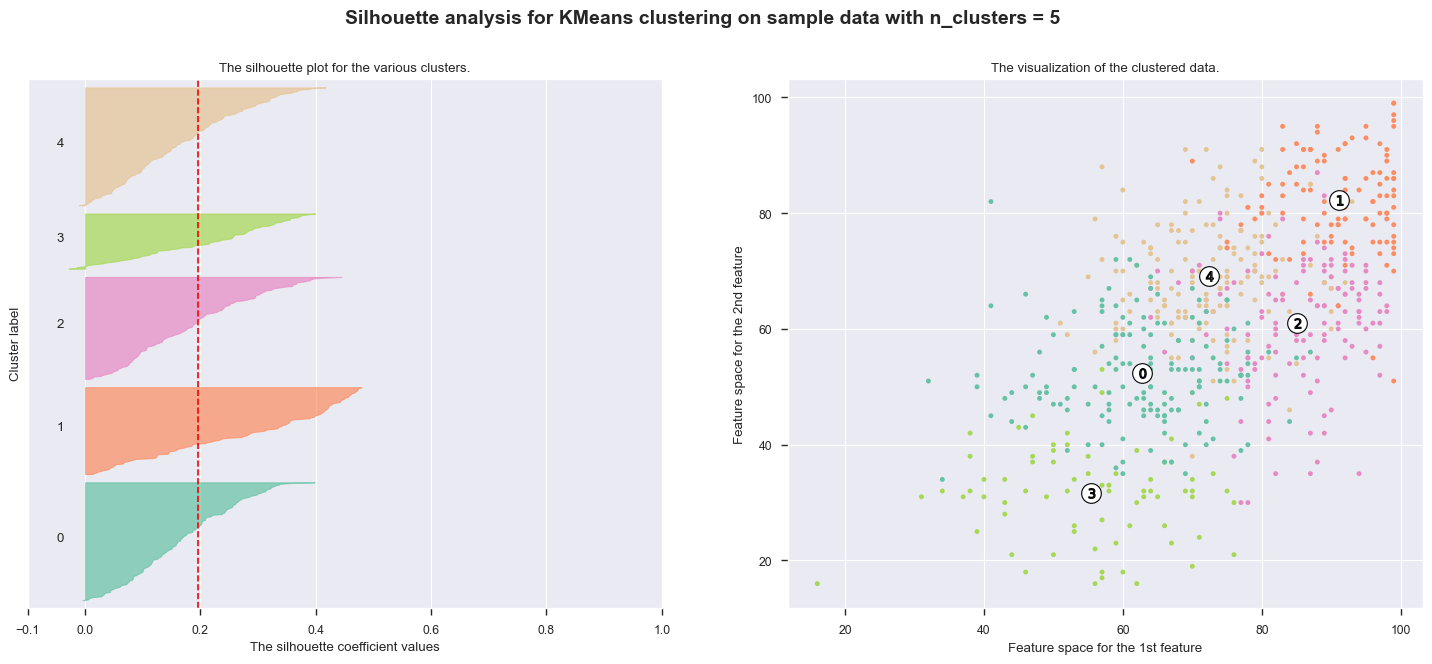

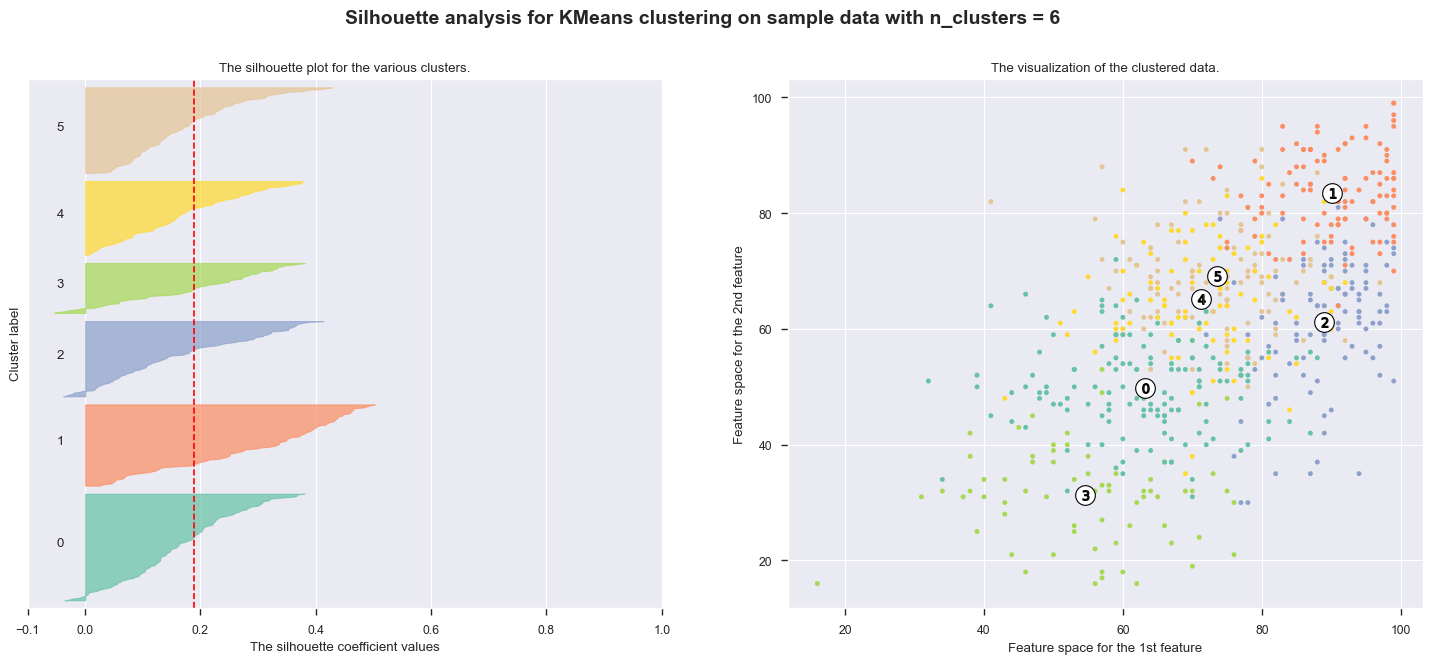

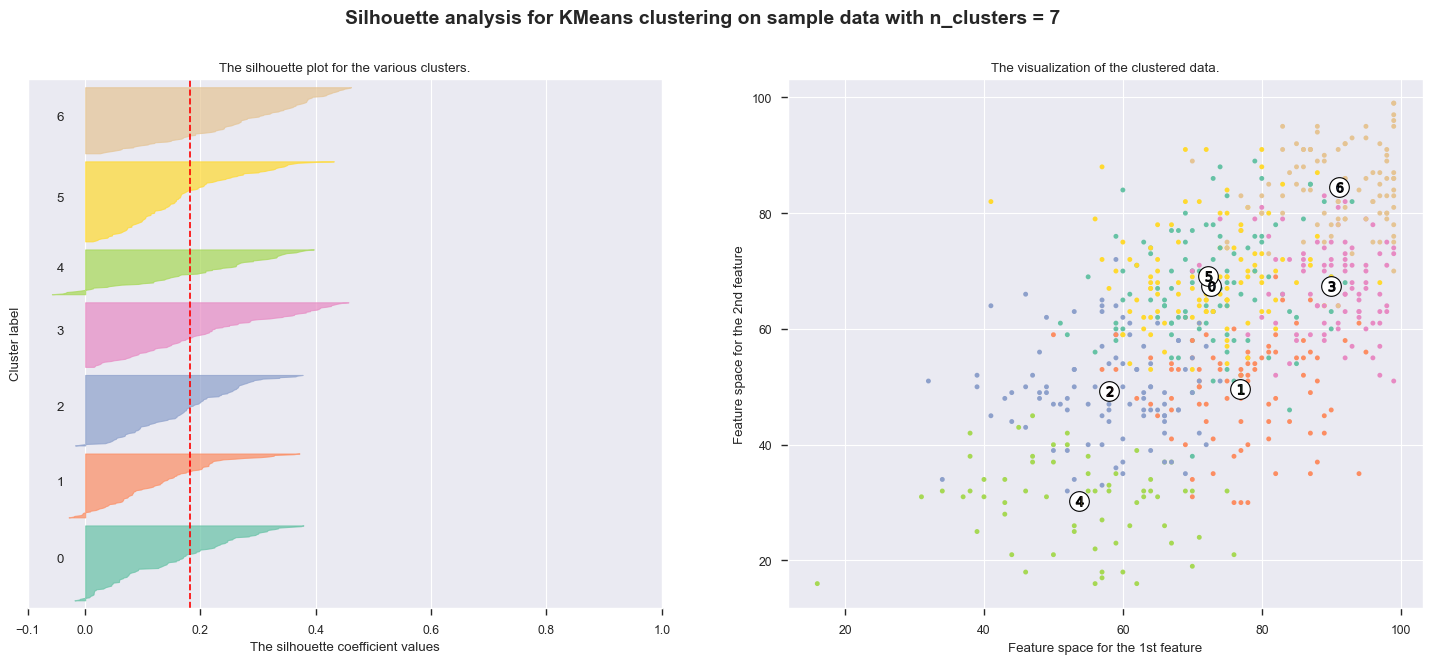

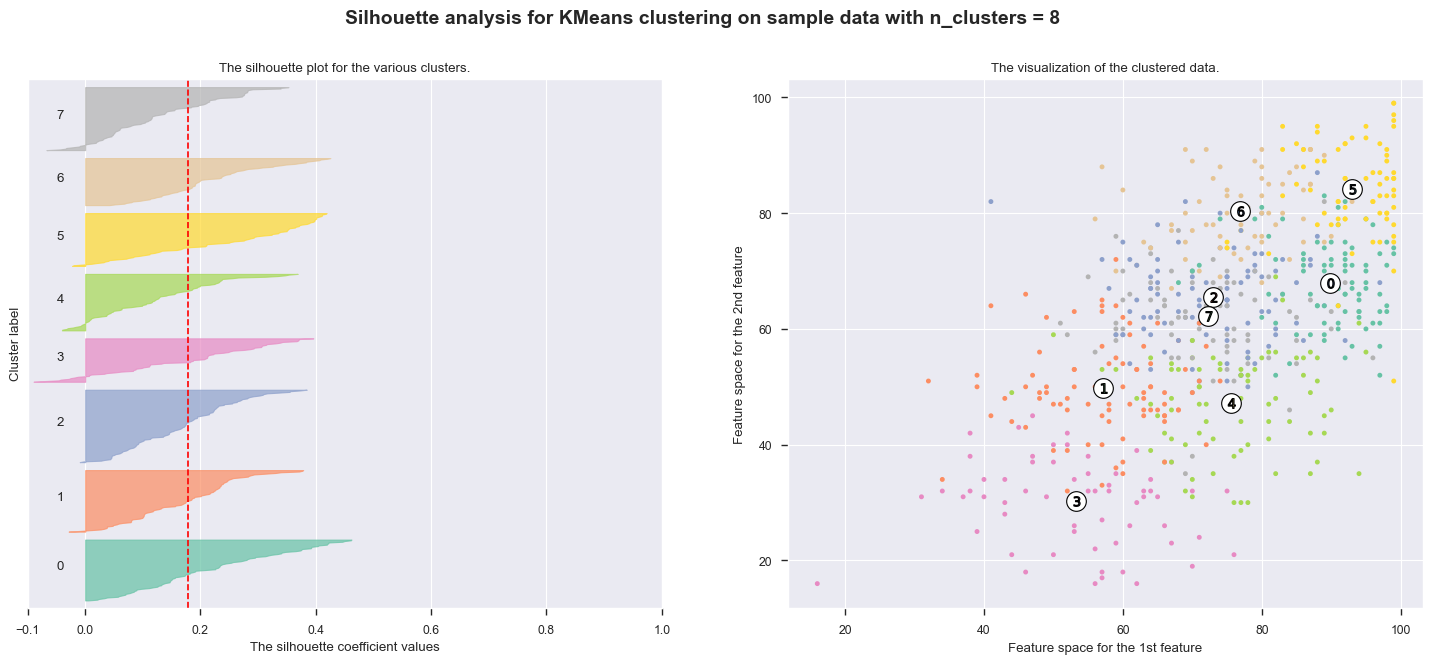

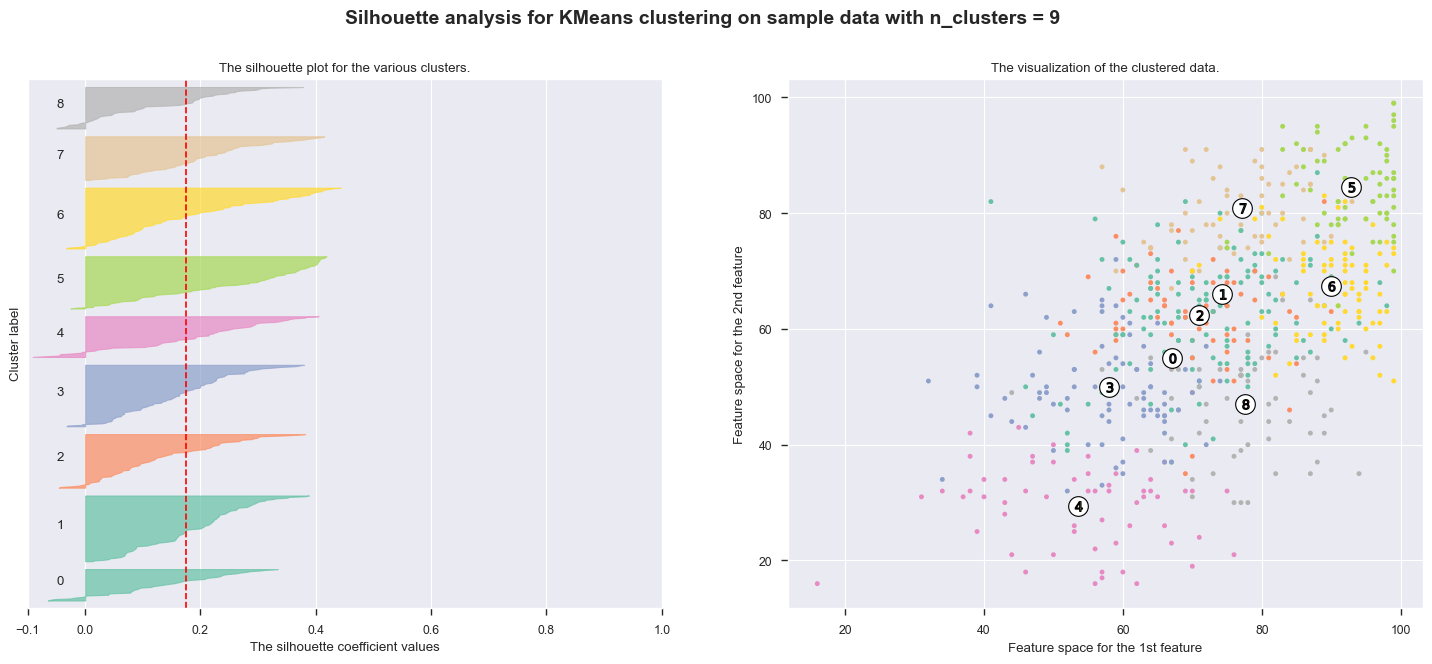

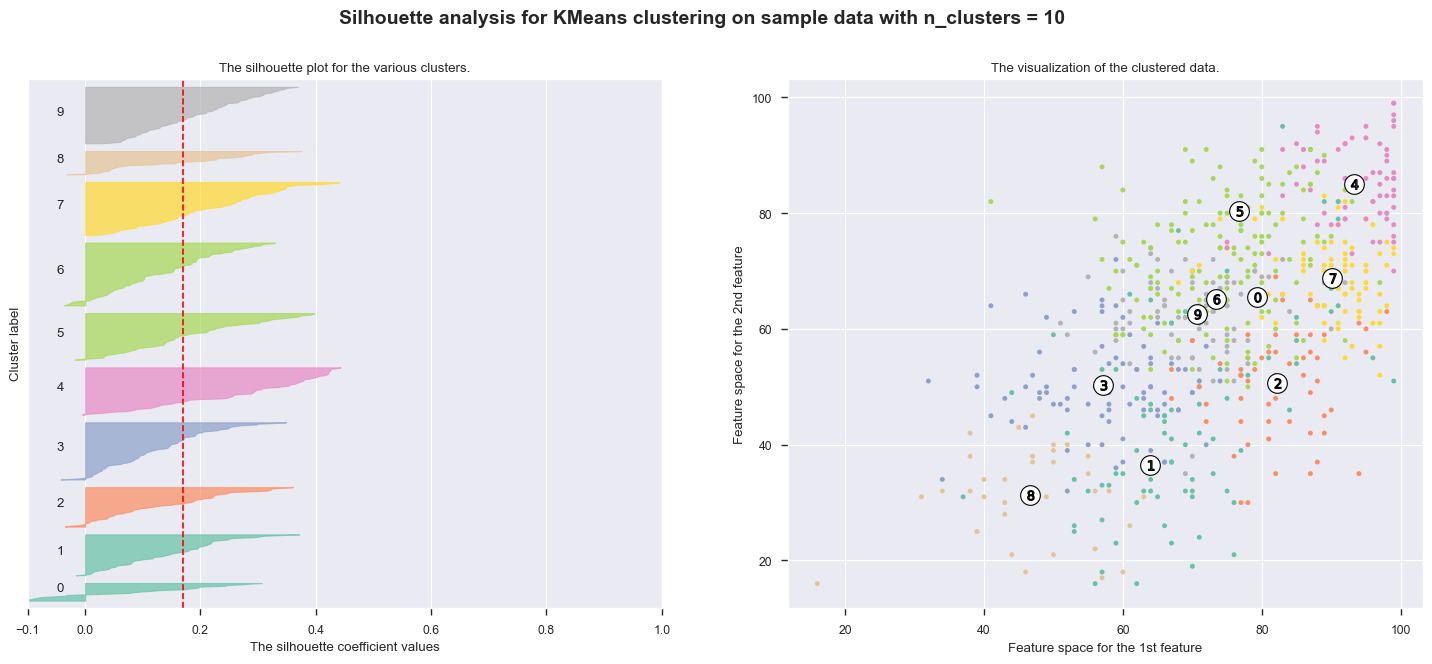

In [41]:
### COPIED FROM https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html###

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Set2(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Set2(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=50, lw=0, alpha=1,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show();

In [283]:
def get_cluster_counts(model_class, param, values, additional_params={}):
    '''
    Given a model class and a parameter with a list of values, 
    get the resulting number of clusters
    '''
    cluster_counts = []
    
    print(param + ':')
    for value in values:
        print(str(value) + ' ', end='')
        param_dict = {param: value}
        param_dict.update(additional_params)
        model = model_class(**param_dict).fit(X)
        cluster_count = len(model.cluster_centers_)
        cluster_counts.append(cluster_count)

    print('')
    print('Cluster counts:')
    print(cluster_counts)
    return cluster_counts

In [279]:
def get_final_params(initial_param_values, cluster_counts, min_clusters=2, max_clusters=10):
    '''
    Given an initial list of parameter values and how many clusters were formed for each of them, 
    return a list of unique parameter values that caused a number of clusters within a range.
    '''
    range_clusters = range(min_clusters, max_clusters + 1)
    final_values = []
    
    for i in range_clusters:
        # Find the index in param_values where cluster_counts equals i
        idx = np.argmax(np.array(cluster_counts) == i)
        if idx == 0: # No cluster_counts are less than i, so np.argmax returned 0
            continue
        
        value = initial_param_values[idx] # Value of parameter at index idx in param_values
        print('parameter value: ' + str(value), '--- ' + 'number of clusters: ' + str(i))
        
        final_values.append(value)
        
    final_values.sort()
    return final_values

In [242]:
def scatter_labels(model, labels, centers=None, X=X, x=0, y=1, cmap=cm.Set2, ax=None, title=False):
    '''
    Make a scatter plot with colored clusters.
    '''
    # Model name
    name = model.__class__.__name__
    
    # Prepare colors
    n_clusters = len(set(labels))
    colors = cmap(labels.astype(float) / n_clusters)

    # Make figure    
    if not ax:
        fig, ax = plt.subplots()
    ax.scatter(X[:, x], X[:, y], c=colors, s=4)
    ax.set_xlabel(merged_df.columns[x])
    ax.set_ylabel(merged_df.columns[y])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0,110])
    ax.set_ylim([0,110])

    if title:
        ax.set_title(f'Model: {name}, Clusters: {n_clusters}')
    else:
        ax.set_title(f'Clusters: {n_clusters}')
    
    if centers is not None:
        # Draw white circles at cluster centers
        ax.scatter(centers[:, x], centers[:, y], marker='o',
                    c="white", alpha=1, s=100, edgecolor='k')

        for i, c in enumerate(centers):
            ax.scatter(c[x], c[y], marker='$%d$' % i, alpha=1,
                        s=25, edgecolor='k')

In [289]:
def plot_params(model_class, param, param_values, additional_params={}):
    '''
    Create a grid of cluster-colored scatter plots corresponding to different paramater values for a model.
    '''
    col_tuples = [(0, 1), (2, 3), (4, 5)]
    n_values = len(param_values)
    fig, ax_rows = plt.subplots(3, n_values, sharex=True, sharey=True)
    fig.suptitle(model_class.__name__)
    
    for value_idx, value in enumerate(param_values):
        # Build dictionary with parameters
        param_dict = {param: value}
        param_dict.update(additional_params)
        
        # Fit the model
        model = model_class(**param_dict).fit(X)
            
        # Get labels
        try: 
            labels = model.labels_
        except:
            labels = model.predict(X)
            
        # Get cluster centers
        try:
            centers = model.cluster_centers_
        except:
            centers = None
        
        row = value_idx
        for x, y in col_tuples:
            plt.tight_layout()
            col = x // 2
            ax = ax_rows[col][row]
            scatter_labels(model, labels=labels, centers=centers, x=x, y=y, ax=ax)

### DBSCAN

A big challenge when using DBSCAN is tuning the hyperparameters (epsilon and min_samples).

In [42]:
### Reference: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#
# Get distance to nearest neighbor for each instance. n_neighbors includes the instance itself.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# 0th column is all 0s: distance between each instance and itself
# 1st column is distance between each distance and its closest neighbor
# Here is a (sorted) list of those distances for 20 instances
distances = np.sort(distances[:,1], axis=0)
distances[:20]

array([2.09486124, 2.09486124, 4.35889894, 4.35889894, 4.47940371,
       4.47940371, 4.51535642, 5.07563736, 5.07563736, 5.2824968 ,
       5.2824968 , 5.31696127, 5.31696127, 5.3263842 , 5.3263842 ,
       5.61147354, 5.61147354, 5.83652787, 5.83652787, 5.85864328])

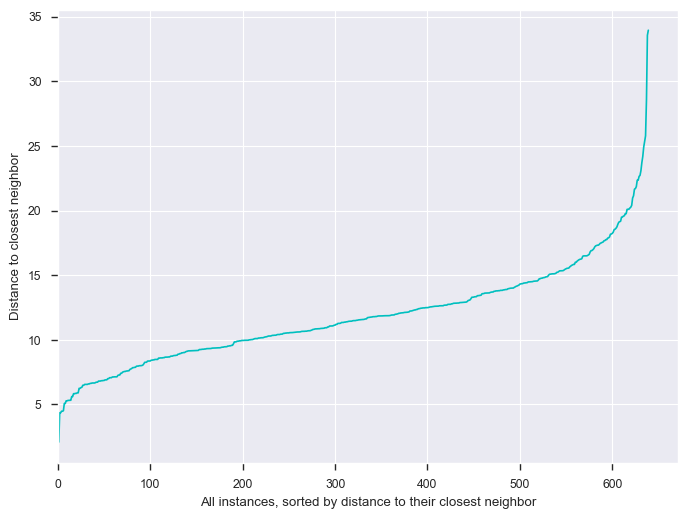

In [43]:
plt.figure(figsize=(8,6))
plt.plot(distances, color='c')
plt.xlim(0)
plt.xlabel('All instances, sorted by distance to their closest neighbor')
plt.ylabel('Distance to closest neighbor')
plt.show();

Ideal epsilon to cluster as many instances as possible while discarding outliers is between 12 and 17. I will choose 15 for now.

In [44]:
### Reference: https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289
dbscan = DBSCAN(eps=18, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=18)

In [45]:
pd.Series(dbscan.labels_).value_counts()

 0    568
-1     72
dtype: int64

### Explore the outliers

In [46]:
outliers_df = merged_df[dbscan.labels_ == -1]
outliers_df

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment,income
5,68.0,77.0,74.0,92.0,66.0,100.000000
11,43.0,28.0,25.0,51.0,22.0,49.957311
18,62.0,16.0,30.0,51.0,46.0,49.957311
34,70.0,49.0,57.0,79.0,70.0,79.928924
53,85.0,54.0,57.0,84.0,54.0,79.928924
...,...,...,...,...,...,...
628,41.0,82.0,72.0,24.0,44.0,44.514525
630,67.0,23.0,29.0,25.0,57.0,57.996628
631,47.0,45.0,48.0,18.0,47.0,26.970609
633,57.0,18.0,7.0,33.5,49.0,43.874197


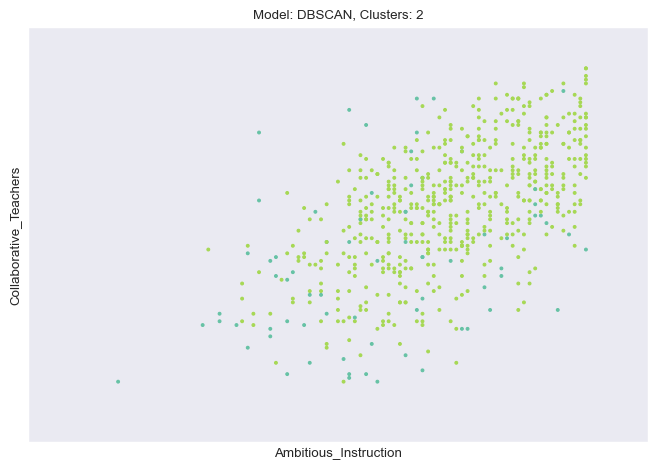

In [248]:
scatter_labels(dbscan, (dbscan.labels_ + 1), title=True)

### Aggloremative Clustering

In [50]:
X = get_fresh_X()

In [51]:
mergings = linkage(X, 'ward')

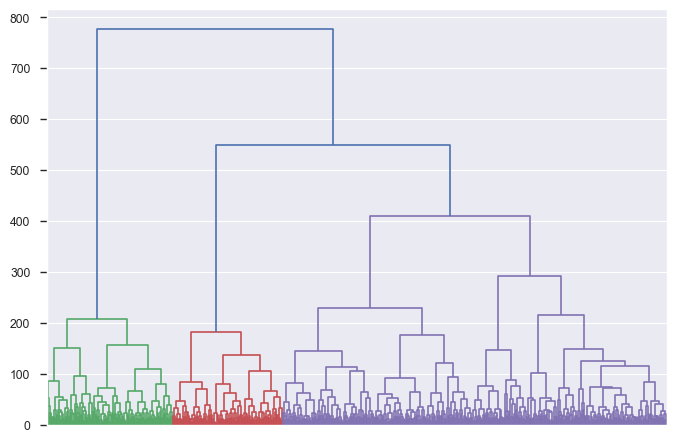

In [52]:
dendrogram(mergings, no_labels=True)
plt.show();

Looking at the dendrogram, it seems like n_clusters should be 2, 3 or 4.

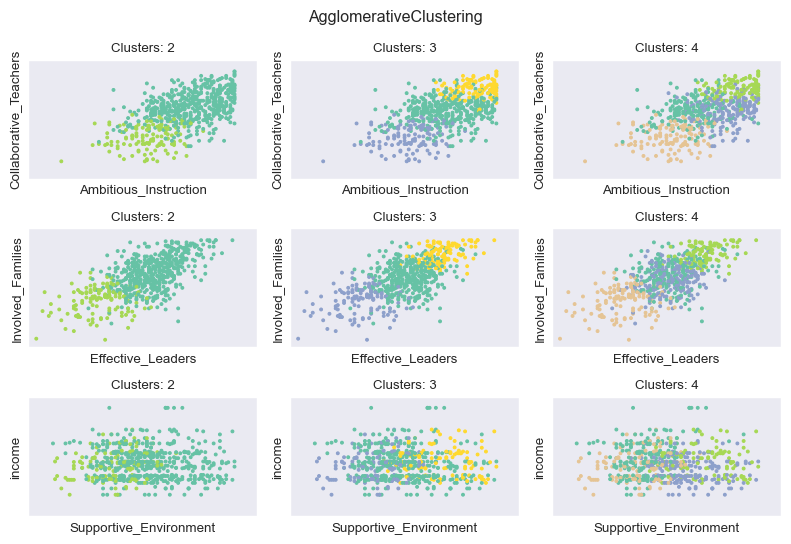

In [255]:
plot_params(AgglomerativeClustering, 'n_clusters', [2, 3, 4])

### Mean-Shift

In [54]:
X = get_fresh_X()

In [55]:
bandwidth = estimate_bandwidth(X)
bandwidth

40.9875536484043

In [274]:
ms_cluster_counts = get_cluster_counts(MeanShift, 'bandwidth', np.arange(10, 60, 2))

bandwidth:
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 
Cluster counts:
[495, 356, 229, 132, 74, 43, 24, 14, 5, 4, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


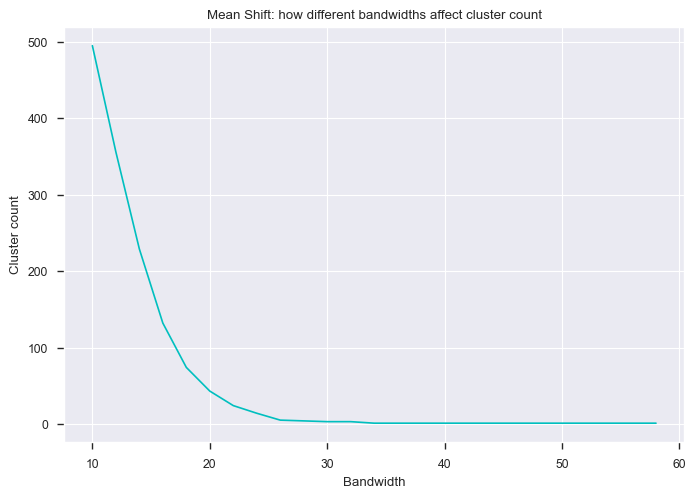

In [160]:
plt.plot(bw_list, ms_cluster_counts, color='c')
plt.xlabel('Bandwidth')
plt.ylabel('Cluster count')
plt.title('Mean Shift: how different bandwidths affect cluster count')
plt.show()

In [280]:
bws = get_final_params(initial_param_values=bws_initial,
           cluster_counts=ms_cluster_counts)

parameter value: 30 --- number of clusters: 3
parameter value: 28 --- number of clusters: 4
parameter value: 26 --- number of clusters: 5


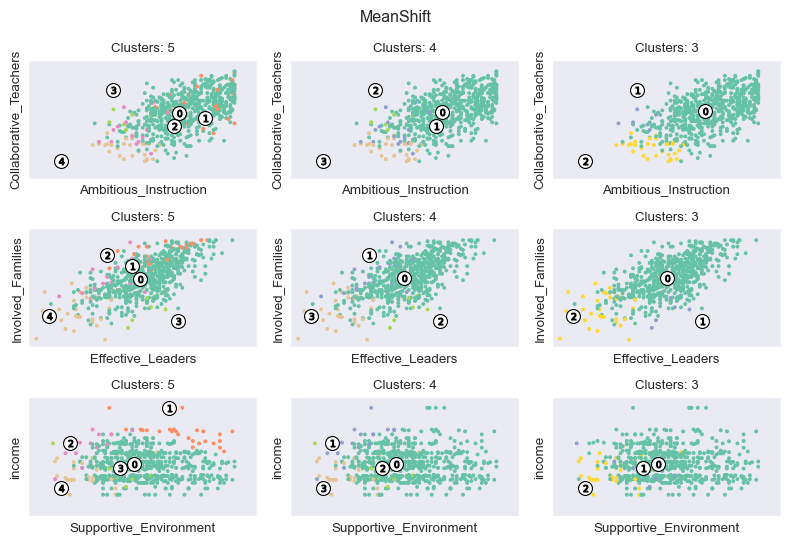

In [256]:
plot_params(MeanShift, 'bandwidth', bws)

"In real use cases we can’t look at the data and realise points are not really in a cluster; we have to take the clustering algorithm at its word."
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#affinity-propagation

### Affinity propagation

In [124]:
X = get_fresh_X()

In [127]:
affinity = AffinityPropagation(random_state=random_state).fit(X)

In [284]:
ap_cluster_counts = get_cluster_counts(AffinityPropagation, 
                   'preference', 
                   np.arange(-1000000, 0, 10000),
                   {'damping': 0.9, 'random_state': random_state})

preference:
-1000000 -990000 -980000 -970000 -960000 -950000 -940000 -930000 -920000 -910000 -900000 -890000 -880000 -870000 -860000 -850000 -840000 -830000 -820000 -810000 -800000 -790000 -780000 -770000 -760000 -750000 -740000 -730000 -720000 -710000 -700000 -690000 -680000 -670000 -660000 -650000 -640000 -630000 -620000 -610000 -600000 -590000 -580000 -570000 -560000 -550000 -540000 -530000 -520000 -510000 -500000 -490000 -480000 -470000 -460000 -450000 -440000 -430000 -420000 -410000 -400000 -390000 -380000 -370000 -360000 -350000 -340000 -330000 -320000 -310000 -300000 -290000 -280000 -270000 -260000 -250000 -240000 -230000 -220000 -210000 -200000 -190000 -180000 -170000 -160000 -150000 -140000 -130000 -120000 -110000 -100000 -90000 -80000 -70000 -60000 -50000 -40000 -30000 -20000 -10000 
Cluster counts:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [281]:
prefs = get_final_params(prefs_initial, ap_cluster_counts)

parameter value: -330000 --- number of clusters: 2
parameter value: -170000 --- number of clusters: 3
parameter value: -50000 --- number of clusters: 4
parameter value: -40000 --- number of clusters: 5
parameter value: -20000 --- number of clusters: 9


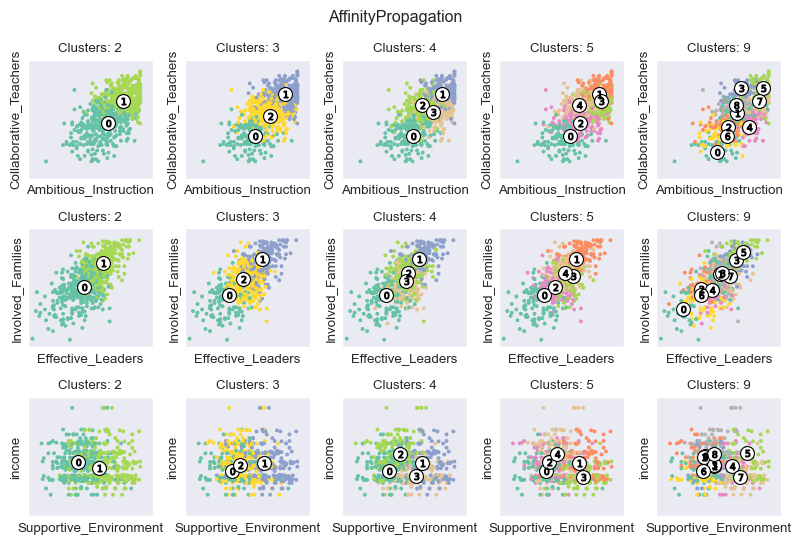

In [238]:
additional_params = {'damping': 0.9, 
                     'random_state': random_state}

plot_clusters(AffinityPropagation, 'preference', prefs, additional_params)

### Gaussian Mixtures

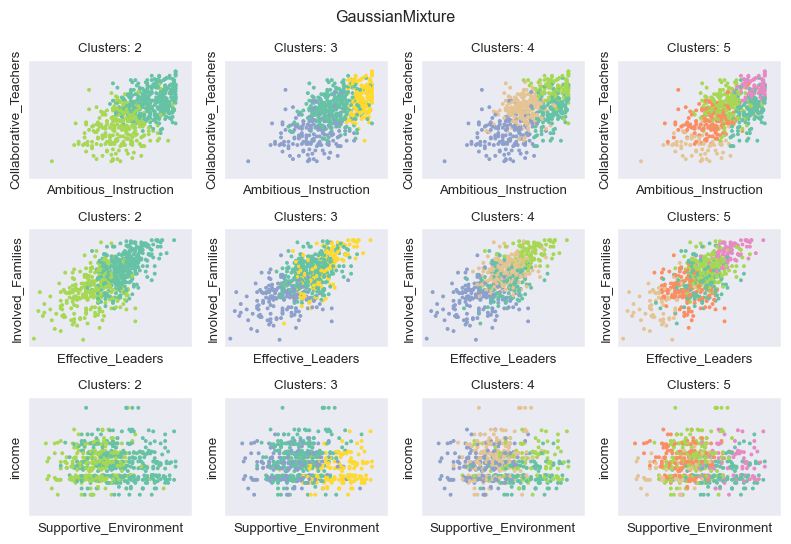

In [290]:
plot_params(GaussianMixture, 'n_components', np.arange(2, 6), {'random_state': random_state})

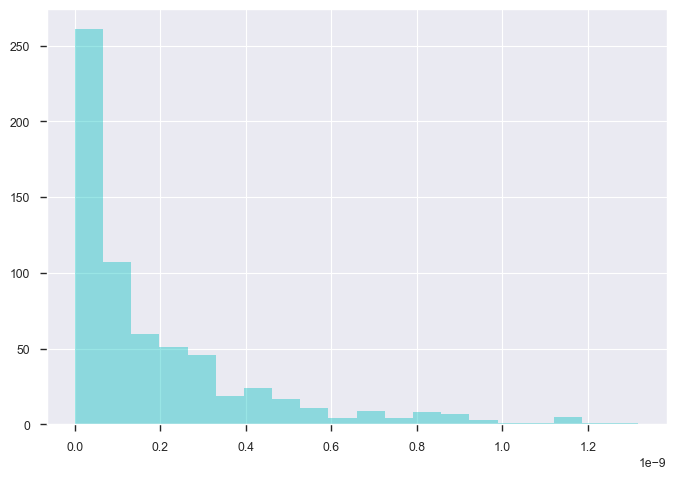

In [314]:
# Probability
plt.hist(np.exp(gm2.score_samples(X)), bins=20, **viz_config);